# Microsoft Films Industry Analysis

## Overview

This project analyzes theatrical films with intention of guiding Microsoft through the launch of its new film studio.  The results of these analyses will yield actionable insights that Microsoft's new studio head can use to determine what types of films to develop.

### Business Problem

Releasing movies is a daunting endeavor.  Not only will it require millions, if not hundreds of millions of dollars to fund wide theatrical releases, it will also require a deep understanding of what today's audiences are willing to watch.  Before sending films into production, we need to know what genre of film people are willing to see how we can ensure that audiences have an opportunity to see the film.

### Data Understanding

Without years of experience in the industry, our best bet will be to take a look at a large yet targeted sample of theatrical releases.  There are many websites dedicated to box office and film data.  For this project, we will source our data using The Movie Databse's API.

TMDB offers a sound and comprehensive dataset that will be a good foundation for our initial research.  The site has detailed information on over 500,000 theatrical releases throughout history.  While it would be interesting to analyze every film in the database, it would be more apt to target our research in the direction of films that Microsoft is likely to produce.

This project assumes a few things:
- Microsoft is a for profit organization and will be interested in making movies that have a broad market appeal.
- At the beginning of this venture, be focused exclusively on wide releases, and will not enter films into the festival circuit.
- While it is generally preferable to release movies that are highly acclaimed, Microsoft will use historical production budget and box office revenue to indicate success.  In other words, we believe that movie goers will vote on what they like with their wallets.

## Data Intake

Before collecting data, we will want to import a selection of Python packages.

Note - a variable called 'scrape' has been implemented to prevent scraping.  When set to 'True,' it will perform the full scrape.  When set to 'False,' it will skip the scraping steps.  Code has been implemented to use datasets stored in the git repository, but these databases were originally sourced using the TMDB API.

In [269]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)
keys = get_keys("/Users/Johnny/.secret/yelp_api.json")
api_key = keys['api_key']
# pip install tmdbsimple #Ctrl+? this line to install tmdbsimple
import tmdbsimple as tmdb
tmdb.API_KEY = api_key

scrape = False

First, we will use the TMDB API to pull movies using our initial filters, which have been applied when considering Microsoft's goals:

- Release year (2012-2019) - audience taste and movie trends continue to evolve.  We want to focus on the post Avengers era, which began in 2012.  While franchise movies have been popular since the early 2000s, The Avengers marked the beginning of series based films.  While Marvel has had the most success with this format, many other studios have been trying to utilize their own intellectual property in an attempt to replicate Disney's success.  Also, 2020 was removed from the analysis due to the dramatic impact that the pandemic had on box office revenues.  It would be appropriate to resume analysis when theaters are allowed to screen nationwide in full capacity and when audiences feel comfortable returning to theaters.
- Original language (English) - Microsoft will likely be making films in the English language.  It is possible that this could change with international revenues representing a larger proportion of overall box office returns.  Also, in earlier tests with the API, we found that TMDB has a large collection of movies that are not targeted for global audiences.
- Runtime (greater than 80 minutes) - TMDB also contains a wealth of shorter films.  'Feature length' is generally defined as 90 mintues or longer.  We lowered our requirement to 80 minutes to account for movies that are still considered 'feature length,' but fall just shy of the rule of thumb.
- Release type (3) - TMDB tracks movies that released in 'premiere' or 'limited' format.  These represent movies that are released in a relatively small amount of theaters.  Microsoft will likely want to target broad audiences, which is best represented by release type 3 ('Theatrical).  An explanation of 'Theatrical' can be found here: https://developers.themoviedb.org/3/movies/get-movie-release-dates, and the code indicating that '3' is the appropriate release type for the API can be found here: https://developers.themoviedb.org/3/movies/get-movie-release-dates.

In [270]:
if scrape == True:

    results = []

    for year in [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:

        page_number = 1

        response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' 
                                 +  api_key + '&page=' + str(page_number) + 
                                 '&with_original_language=en&primary_release_year=' + str(year) + '&with_release_type=3&with_runtime.gte=80')

        total_pages = response.json()['total_pages']
        # total_pages = 5

        results.extend(response.json()['results'])

        while page_number < total_pages:

            page_number += 1

            response = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' 
                                 +  api_key + '&page=' + str(page_number) + 
                                 '&with_original_language=en&primary_release_year=' + str(year) + '&with_release_type=3&with_runtime.gte=80')

            results.extend(response.json()['results'])
            
        results.to_csv('data/2012-2019.csv')
            
else: print('Scrape is set to False.')



Scrape is set to False.


We will also be using a python wrapper called "tmdbsimple," which will allow more intuitive coding for scraping later in the notebook.

In [271]:
pip install tmdbsimple
import tmdbsimple as tmdb
tmdb.API_KEY = api_key

SyntaxError: invalid syntax (<ipython-input-271-2077d176f901>, line 1)

In [ ]:
#Importing via CSV to avoid large scrape

df = pd.read_csv('data/2012-2019.csv')

In [ ]:
df.head(3)

Previewing our results, we find useful information, but we're missing a few key pieces of data that we will want to explore in our analysis.  For our analysis, we will also want information on movie production budget, global box office revenue, and MPAA rating.  Budget and revenue will allow us to examine profitability, and MPAA rating will be analyzed later in the notebook.

This script uses the TMDB API to loop through every movie in our dataset and pull additional movie details.

In [ ]:
if scrape == True:

    df_ids = df['id']

    full_movies = []

    for idx in df_ids:
        movie = tmdb.Movies(idx)

        movie_dic = {}

        movie_dic.update(movie.info())

        movie.releases()
        for c in movie.countries:
            if c['iso_3166_1'] == 'US':
                certification = c['certification']
    #         else:
    #             certification = 'None'

        movie_dic.update({'mpaa_rating' : str(certification)})

        full_movies.append(movie_dic)

    df_full = pd.DataFrame(full_movies)

    df_full.to_csv('data/2012-2019 FULL.csv')
    
else: print('Scrape is set to False.')
    
#### 293471 & 437584 didn't work, make sure to write how i worked around

In [ ]:
#Importing via CSV to avoid large scrape

df_full = pd.read_csv('data/2012-2019 FULL.csv')

df = df_full

print(df.shape)

df.head(3)

Now that we have pulled everything we need from TMDB, we will want to continue refining our dataset.  Let's take a look at the columns to better understand what types of data we can examine.

In [ ]:
#https://datatofish.com/list-column-names-pandas-dataframe/

column_list = df.columns.values.tolist()

print(column_list)



Most of these columns can be useful in future analyses, but for now, let's select only the columns we'll need for this project.

In [272]:
# df.drop(columns=[columns_to_drop], inplace=True)

df = df[['release_date', 'original_title', 'id', 'budget', 'revenue', 'mpaa_rating', 
    'genres', 'popularity', 'vote_average', 'vote_count', 'runtime', 
    'production_companies']]

df.shape

(1365, 12)

Now, we'll want to remove movies that will not be comparable to Microsoft's wide theatrical release strategy.  In analyzing some examples, we find that many movies have very low budgets (likely independent films) or zero for revenue.  For budget, we will assume that Microsoft will spend at least $1,000,000 (and likely much more) on every film they produce.  

Upon closer examination of the $0 revenue movies, we find cases where TMDB data isn't airtight and other off examples like Netflix movies that technically released in theaters, but revenue might not have been widely reported.  Even 

In [273]:
df = df.loc[df['budget'] >= 1000000] #budget greater than $1mm
df = df.loc[df['revenue'] != 0] #revenue greater than 0, movies with zero indicate no 'real' release

print(df.shape)

(1365, 12)


# Production Budget and Box Office Revenue

Our dataframe is ready for analysis!

To start, we will take a look at how many films were successful, and how many films failed.  For the purposes of this analysis, "success" will be defined as any movie whose box office revenue exceeded its production budget.  Any movie that failed to recoup its budget with box office revenue will be deemd a "flop."

We have budget and revenue already, so let's calculate profit using these two fields.

In [274]:
# insert column tip from: https://discuss.codecademy.com/t/can-we-add-a-new-column-at-a-specific-position-in-a-pandas-dataframe/355842/2

profit = df['revenue'] - df['budget']

df.insert (5, "profit", profit)

df.head(3)

,release_date,original_title,id,budget,revenue,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,1298815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,709000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,306222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


Next we'll make a column that tells us whether or not the movie was a success or a flop.  We will answer whether or not a movie is successful with a 'Yes' or a 'No.'

In [275]:
# https://stackoverflow.com/questions/56990755/how-to-create-a-boolean-column-depending-on-positive-or-negative-values-of-anoth      


successful = np.where(df["profit"] >= 0, 'Success', 'Flop')

df.insert (5, "successful", successful)

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Success,1298815515,PG-13,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Success,709000000,PG-13,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Success,306222889,PG,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


And we'll check to make sure we answered for every movie.

In [276]:
df['successful'].unique()

array(['Success', 'Flop'], dtype=object)

Finally, we'll visualize our findings with a Seaborn regression model.  This will show us the dispersion of budget and revenue for our dataset.  Also, we will colorize the successes and flops so that they're easy to distinguish.

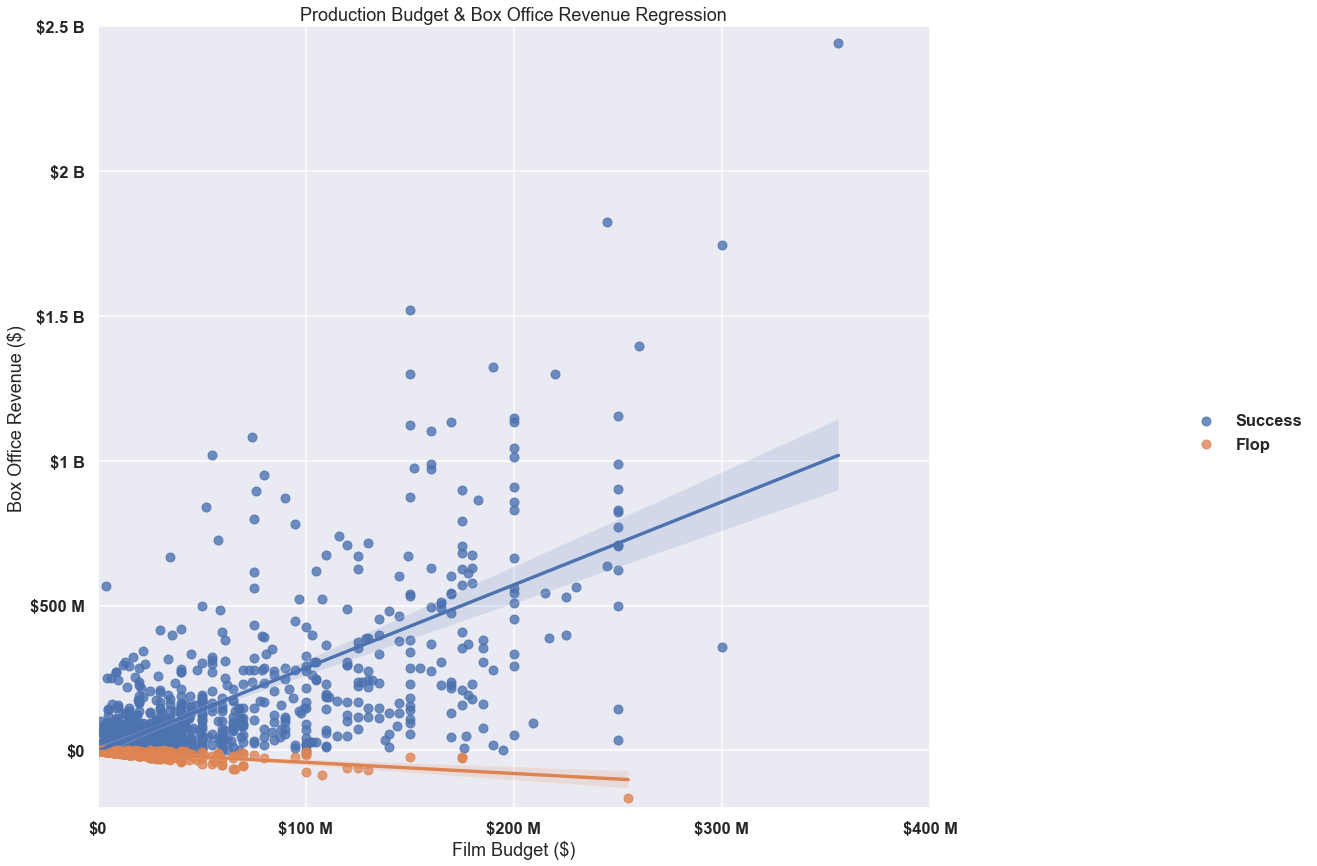

In [277]:
import seaborn as sns; sns.set_theme(color_codes=True)

sns.set_context('talk')

g = sns.lmplot(x="budget", y="profit", data=df, hue="successful")

g.fig.set_size_inches(20,15)

g = g.set_axis_labels("Film Budget ($)",
    "Box Office Revenue ($)").set(xlim=(0, 400000000), 
    ylim=(-200000000, 2500000000),
    xticks=[0, 100000000, 200000000, 300000000, 400000000], 
    yticks=[0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000],
    title='Production Budget & Box Office Revenue Regression')

g.set_xticklabels(['$0', '$100 M', '$200 M','$300 M','$400 M'])
g.set_yticklabels(['$0', '$500 M', '$1 B', '$1.5 B', '$2 B', '$2.5 B'])

g.legend.set_title(None)

plt.show()


# Genre

Our dataset also contains information on genres.  Each film can have one or multiple genres.  The column looks like a dictionary, but it is actually formatted as a string.  We will convert the strings to dictionaries, extract the genre names from the dictionaries, and replace every movie's genre value with a list of its genres.

In [278]:
df_genre_list = []

for row in df['genres']:
    row = list(eval(row))
    row_genres = []
    for item in row:
        row_genres.append(item['name'])
    
    df_genre_list.append(row_genres)
    
df['genres'] = df_genre_list

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies
0,4/25/2012,The Avengers,24428,220000000,1518815515,Success,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ..."
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Success,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f..."
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Success,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil..."


Next, we will use the pandas explode and groupby functions 

In [279]:
genre_mean_df = df.explode('genres').groupby('genres').mean().round()
genre_median_df = df.explode('genres').groupby('genres').median().round()

# reset index so that seaborn will work, will not work with columsn as index
# genre_name = []

genre = genre_mean_df.index

genre_mean_df.reset_index(drop=True, inplace=True)
genre_mean_df.insert (0, "genre", genre)

genre_median_df.reset_index(drop=True, inplace=True)
genre_median_df.insert (0, "genre", genre)

In [280]:
genre_mean_df.head(3)

,genre,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime
0,Action,242281.0,83442070.0,275878015.0,192435944.0,54.0,6.0,4671.0,113.0
1,Adventure,240311.0,110242334.0,396482517.0,286240183.0,55.0,7.0,5549.0,113.0
2,Animation,248863.0,85701402.0,343391802.0,257690400.0,41.0,7.0,3422.0,95.0


In [281]:
genre_median_df.head(3)

,genre,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime
0,Action,257344.0,60000000.0,133718711.0,68761661.0,36.0,6.0,3323.0,112.0
1,Adventure,261507.0,103000000.0,255825100.0,138622422.0,38.0,7.0,4052.0,110.0
2,Animation,261812.0,75000000.0,218349271.0,147401898.0,34.0,7.0,2096.0,93.0


Here we graph the median BO returns and budgets and stack them in bar charts.  The light blue color represents profit.  While I liked this graph, it doesn't show the losses for Westerns, which did not return a profit.  

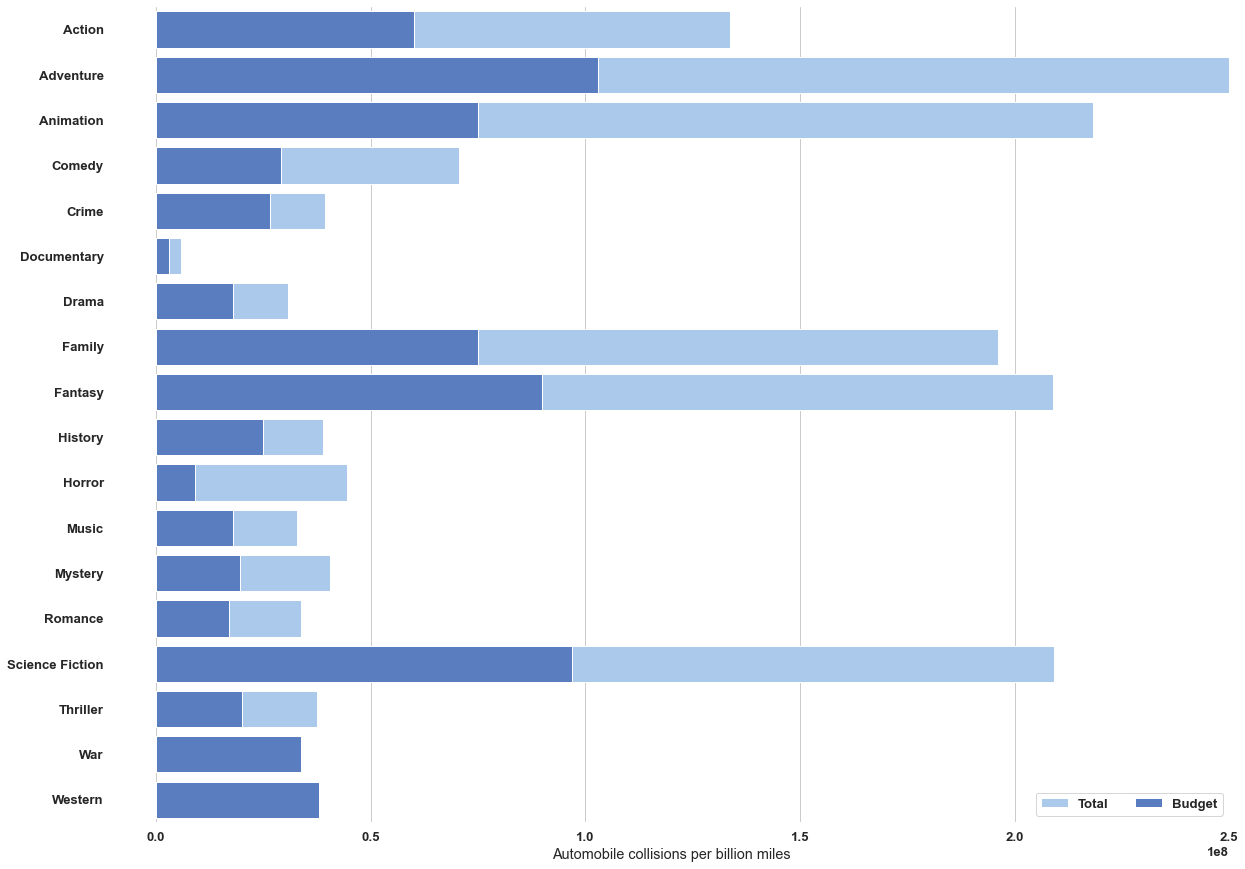

In [282]:
data = genre_median_df

# https://seaborn.pydata.org/examples/part_whole_bars.html
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context('notebook', font_scale=1.2)
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Plot the total crashes
sns.set_color_codes("pastel")



sns.barplot(x="revenue", y="genre", data=data,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="budget", y="genre", data=data,
            label="Budget", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-10000000, 250000000), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

We will instead use a clustered bar chart using matplotlib so that the loss in Westerns is noticeable.

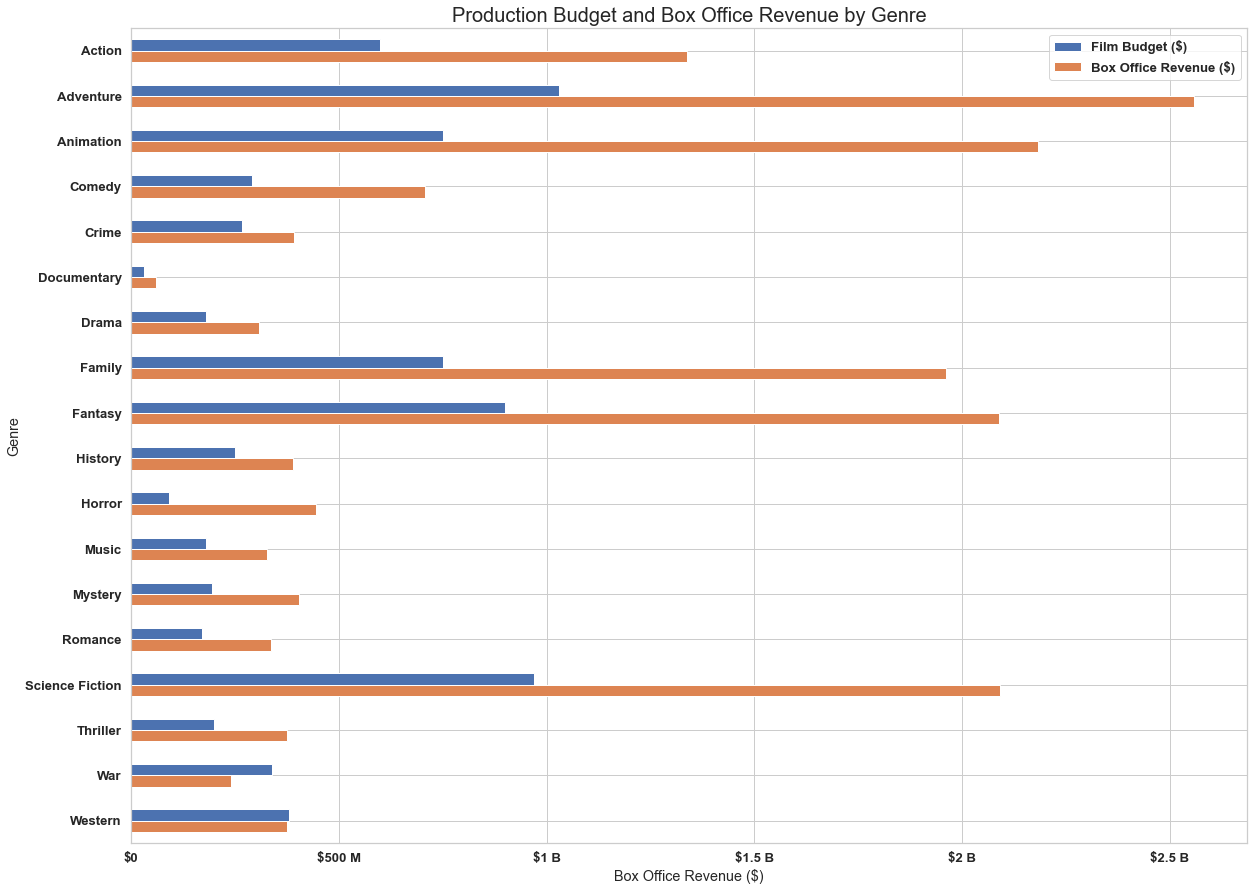

In [283]:
# https://www.delftstack.com/howto/matplotlib/pandas-plot-multiple-columns-on-bar-chart-matplotlib/
# https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot#:~:text=If%20you%20want%20to%20disable,False%2C%20style%3D'plain')%20.
import pandas as pd 
import matplotlib.pyplot as plt 

data = genre_median_df
data.plot(x="genre", y=["budget", "revenue"], kind="barh",figsize=(20,15), legend='reverse')

plt.legend((["Film Budget ($)", "Box Office Revenue ($)"]))
ax = plt.gca()
ax.set_xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000])
ax.set_xticklabels(['$0', '$500 M', '$1 B', '$1.5 B', '$2 B', '$2.5 B'])
ax.set_title('Production Budget and Box Office Revenue by Genre', fontsize=20)
plt.ylabel('Genre')
plt.xlabel('Box Office Revenue ($)')

ax.invert_yaxis()

plt.show()

# MPAA Ratings

Let's take a look at our values for MPAA ratings.

In [284]:
df.head()

df['mpaa_rating'].value_counts()

R        575
PG-13    489
PG       167
NR        14
G          9
NC-17      1
Name: mpaa_rating, dtype: int64

I created an ROI column, which should better represent the films visually in a single bar chart.

In [285]:
df['ROI'] = ((df['profit'] / df['budget']) * 100)

df.head(3)

,release_date,original_title,id,budget,revenue,successful,profit,mpaa_rating,genres,popularity,vote_average,vote_count,runtime,production_companies,ROI
0,4/25/2012,The Avengers,24428,220000000,1518815515,Success,1298815515,PG-13,"[Science Fiction, Action, Adventure]",151.095,7.7,24252,143.0,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",590.370689
1,11/13/2012,The Twilight Saga: Breaking Dawn - Part 2,50620,120000000,829000000,Success,709000000,PG-13,"[Adventure, Fantasy, Drama, Romance]",73.226,6.5,6978,115.0,"[{'id': 491, 'logo_path': '/rUp0lLKa1pr4UsPm8f...",590.833333
2,11/1/2012,Wreck-It Ralph,82690,165000000,471222889,Success,306222889,PG,"[Family, Animation, Comedy, Adventure]",70.213,7.3,9690,101.0,"[{'id': 6125, 'logo_path': '/tVPmo07IHhBs4Huil...",185.589630


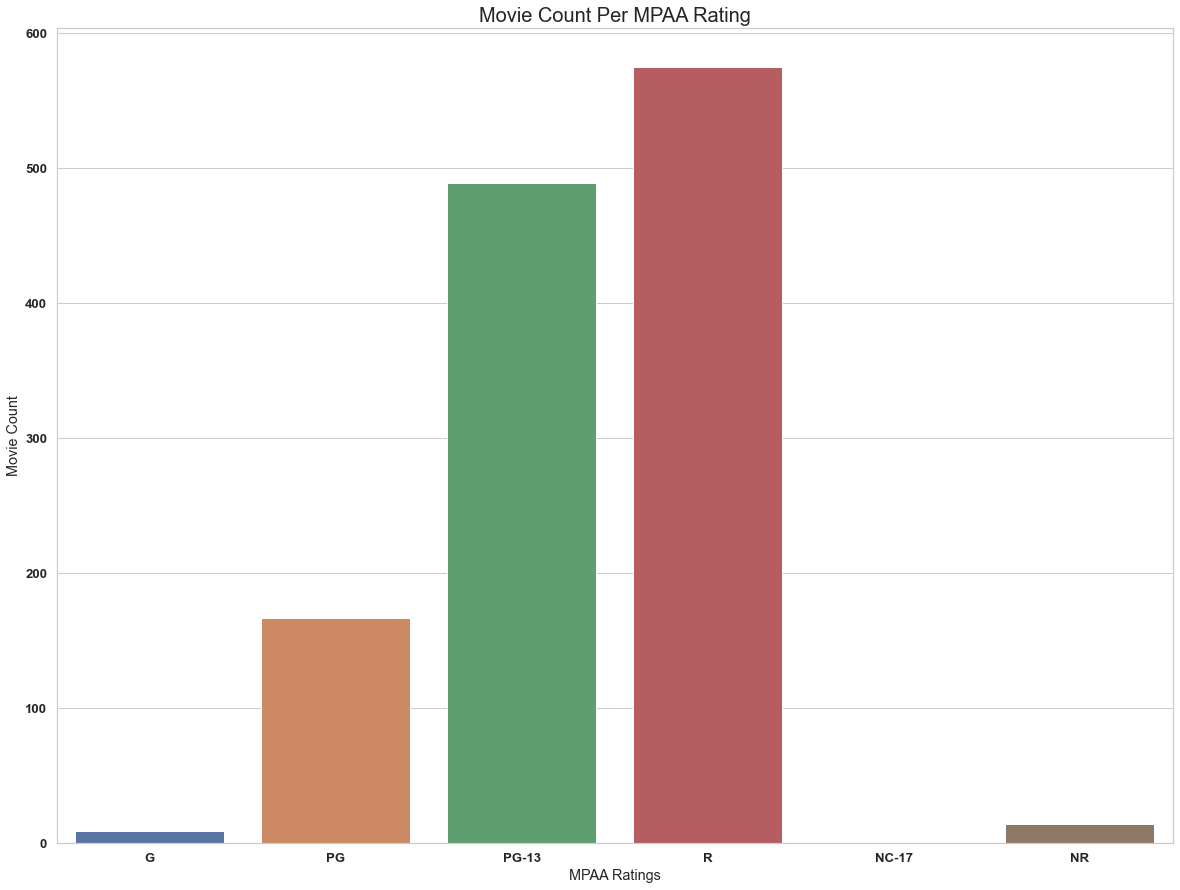

In [286]:
rating_order = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'NR']

f, ax = plt.subplots(figsize=(20, 15))

ax = sns.countplot(data = df, x = 'mpaa_rating', 
    order = rating_order)

ax.set(xlabel='MPAA Ratings', ylabel='Movie Count')

ax.axes.set_title("Movie Count Per MPAA Rating",fontsize=20)

# ax.set_title('test'fontsize=20)

plt.show()

Next we'll use groupby to create new dataframes to examine the mean and median statistics for MPAA ratings.

In [287]:
mpaa_mean_df = df.groupby('mpaa_rating').mean()

mpaa_median_df = df.groupby('mpaa_rating').median()

mpaa_mean_df.reset_index(drop=False, inplace=True)

mpaa_median_df.reset_index(drop=False, inplace=True)

In [288]:
mpaa_mean_df

,mpaa_rating,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime,ROI
0,G,209292.555556,9.388889e+07,3.387722e+08,2.448833e+08,41.207889,6.666667,2635.111111,95.000000,156.135064
1,NC-17,292431.000000,3.000000e+06,2.490830e+05,-2.750917e+06,12.515000,6.300000,1602.000000,134.000000,-91.697233
2,NR,264686.142857,8.892857e+06,5.529222e+06,-3.363635e+06,14.560500,6.300000,765.642857,100.214286,-4.304487
3,PG,262792.179641,7.438131e+07,2.775577e+08,2.031764e+08,34.764533,6.625749,2965.101796,101.586826,283.903548
4,PG-13,245996.862986,6.483038e+07,2.221026e+08,1.572722e+08,41.435546,6.483436,3939.529652,113.145194,272.112563
5,R,261283.382609,2.531680e+07,7.608808e+07,5.077128e+07,29.847487,6.350087,2596.156522,109.721739,276.385744


In [289]:
mpaa_median_df

,mpaa_rating,id,budget,revenue,profit,popularity,vote_average,vote_count,runtime,ROI
0,G,202575.0,99000000.0,246233113.0,147233113.0,27.467,6.80,1180.0,100.0,119.385872
1,NC-17,292431.0,3000000.0,249083.0,-2750917.0,12.515,6.30,1602.0,134.0,-91.697233
2,NR,249149.0,8000000.0,755689.0,-5410070.5,13.237,6.25,479.5,101.0,-58.370360
3,PG,267935.0,64000000.0,133821816.0,78695338.0,27.951,6.70,1633.0,99.0,173.237783
4,PG-13,254905.0,32000000.0,86165646.0,46788393.0,26.567,6.50,2327.0,111.0,146.060104
5,R,257785.0,18000000.0,31724284.0,10361137.0,20.420,6.40,1482.0,107.0,71.439092


Let's plot the results using a Seaborn subplot.  For median, it looks like the highest earning movies tend to be PG and PG-13.  G movies also have strong ROI's, but there are very few in our dataset, so we might not have enough examples to assert that G rated movies consistently return that well.  

R rated movies still have a worthwhile return, but not as strong as the younger age ratings.  The age restriction of R rated movies is likely the cause.  NC-17 ratings are also very negative, but there is only one instance in our ratings.

NR movies ('Not Rated') also have low volume in our data and return negative.  More investigation might be require here to fully understand the impact of this rating on returns.

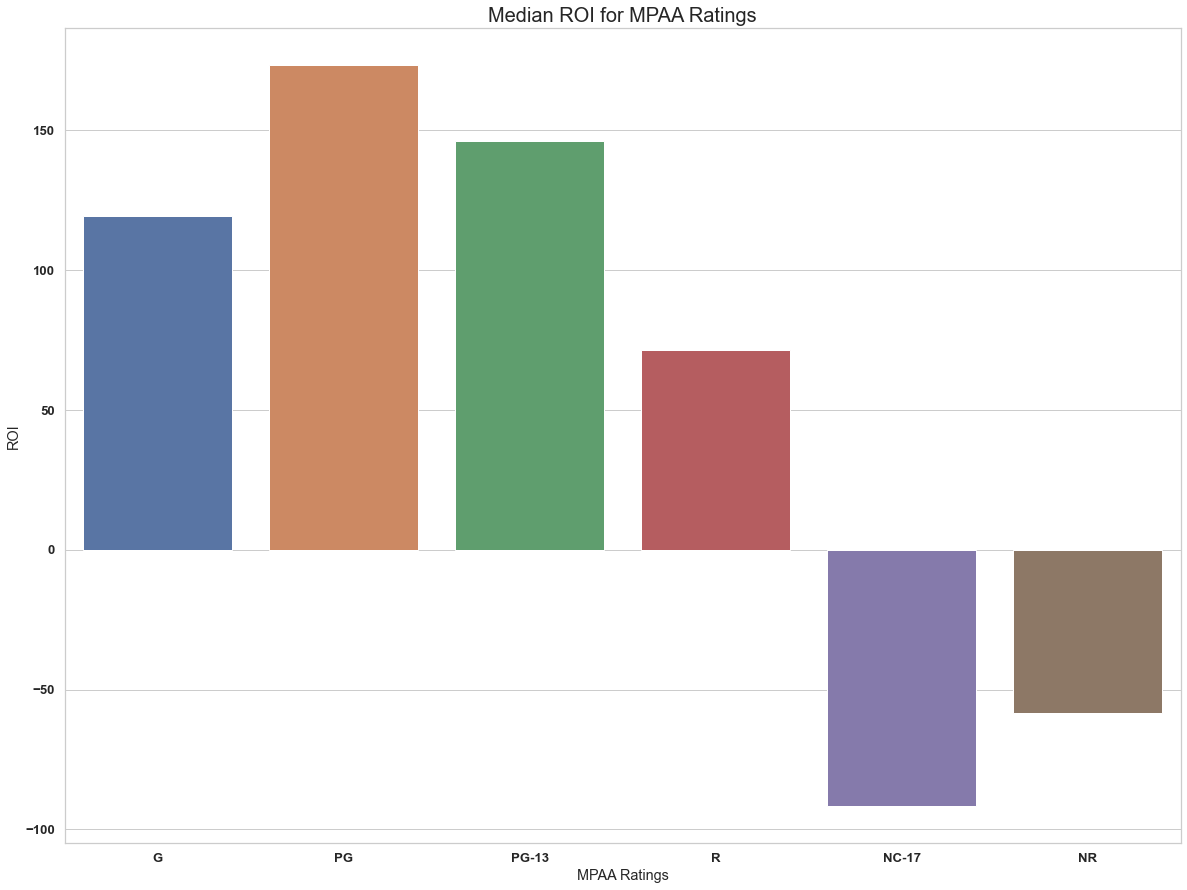

In [290]:
data = mpaa_median_df

rating_order = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'NR']

f, ax = plt.subplots(figsize=(20, 15))

ax = sns.barplot(data = data, x = 'mpaa_rating', 
    y = 'ROI', order = rating_order)

ax.set(xlabel='MPAA Ratings', ylabel='ROI')

ax.axes.set_title("Median ROI for MPAA Ratings",fontsize=20)

plt.show()

Interestingly, the mean values show a much more consistent ROI between PG, PG-13, and R.  This might suggest that some movies with very strong or very low returns skew the results, so the mean might not be the best way to interpret our data.

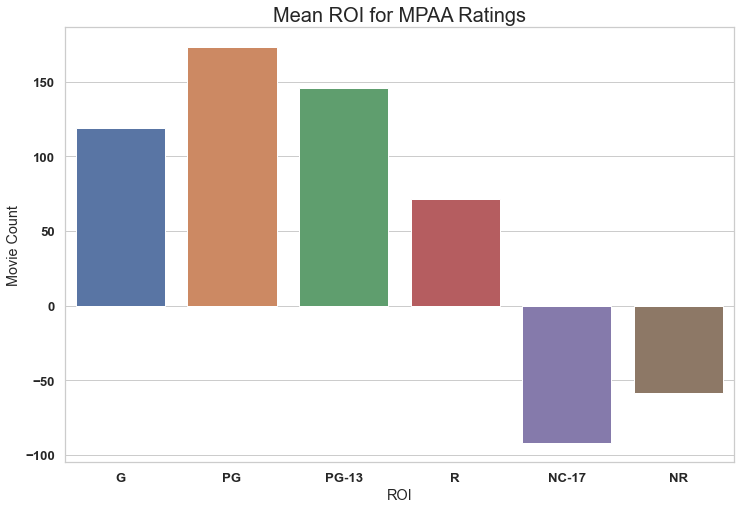

In [291]:
data = mpaa_median_df

rating_order = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'NR']

f, ax = plt.subplots(figsize=(12, 8))

ax = sns.barplot(data = data, x = 'mpaa_rating', 
    y = 'ROI', order = rating_order)

ax.set(xlabel='ROI', ylabel='Movie Count')

ax.axes.set_title("Mean ROI for MPAA Ratings",fontsize=20)

plt.show()

# Conclusions

This analysis yielded three recommendations for Microsoft's first productions:

* **Budget and revenue are correlated, but this does not suggest Microsoft should spend frivolously.**  Our data set is representative of studios and film makers that are guided by profit and have many decades of experience.  Considering Microsoft is new to the business, caution should be taken to avoid box office failures.  
* **For the strongest returns, Microsoft should focus on the Adventure, Animation, Family, Fantasy, and Science Fiction genres.**  Elements of action and comedy can also be considered.  Horror, Music, Mystery, Romance, and Thriller genres have attractive ROI's, but these genres should only be approached with lower budgets in mind.  War and Western movies should be avoided.
* **Microsoft should script movies with the family audience in mind.**  'Edgy' elements can be considered, but a PG-13 rating will have a noticeable impact on ROI.  R ratings should only be considered with lower budget movies, and NC-17 and NR films should be avoided entirely.

# Next Steps

Further analysis could reveal more nuanced insights to help Microsoft in their film venture:

* **What are the commonalities in box office flops?**  Comparing a dataset of unsuccessful films against a dataset with successful films could help solidify or further clarify the findings in this analysis.

* **Deeper examination of individual movie genres.**  Knowing now which genres have the strongest returns, creating a dataset with just Adventure, Family, etc. could reveal trends within those genres.  These can be used to instruct what to pursue and what to avoid.

* **Elementary analysis of franchise films, popularity, production companies, and runtime.**  Given more time, it could be fruitful to analyze these categories in the dataset from this project.

* **Incorporate and compare TMDB dataset against datasets from other sources.**  It would be helpful to solidify our box office revenue and budget data.  We found that some pieces of data in the TMDB dataset conflicted with other sources.  Financing an IMDB API license could yield higher quality data since TMDB data is sourced by users.  Finally, Rotten Tomatoes API should be implemented to understand the relationship between review scores and box office returns.